In this notebook, we'll try to predict whether customers should recieve a promotion in order to maximize IRR and NIT. 

The IRR is the net increase of fraction of customers purchasing between the treatment group (those who receive the promotion) and the control group (those that don't):

$$IRR = \frac{n_{purch_{treat}}}{n_{treat}}  -  \frac{n_{purch_{cont}}}{n_{cont}}$$

The NIR is the increase in revenue between treatment and control groups:

$$NIR = (\$10n_{purch_{treat}} - \$0.15n_{treat}) - \$10n_{purch_{cont} }$$

In [1]:
from test_results import score, test_results

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

train_data = pd.read_csv('./training.csv')

### EDA

Before we train classifiers, we'll visualize and explore the data. Since we're training models for treatment and control groups, we'll vizualize data from these groups side-by-side.

In [2]:
# 0-1 encoding promotion
train_data['Promotion'] = train_data['Promotion'].apply(lambda x: 1 if x == 'Yes' else 0)

/Users/home/opt/anaconda3/envs/dsnd/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


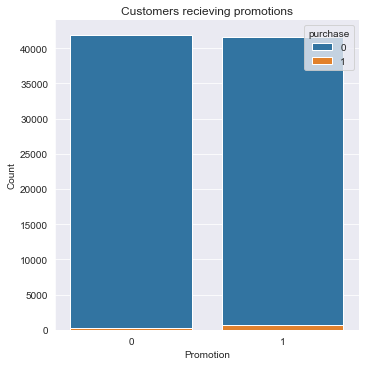

In [3]:
g = sns.FacetGrid(train_data, hue='purchase', height=5)
g.map(sns.countplot, 'Promotion')
plt.title("Customers recieving promotions")
plt.ylabel("Count")
plt.legend(title="purchase");

Our classes are very imbalanced -- few customers in either treatment or control groups actually purchased.

In [4]:
def plot_disc_var(data, var_name, figsize=(10, 4), **kwargs):
    """Plot discrete variables in dataset."""
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    # split into promotion groups
    cont = data.query('Promotion == 0')
    treat = data.query('Promotion == 1')
    # plot control on left
    axs[0].hist([cont.query('purchase == 0')[var_name], 
                 cont.query('purchase == 1')[var_name]], 
                 label=["0", "1"], **kwargs)
    axs[0].set_title('Promotion = 0')
    axs[0].set_xlabel(var_name)
    axs[0].set_ylabel("Frequency")
    axs[0].legend(title="purchase")
    # plot treat on right
    axs[1].hist([treat.query('purchase == 0')[var_name], 
                 treat.query('purchase == 1')[var_name]], 
                 **kwargs)
    axs[1].set_title('Promotion = 1')
    axs[1].set_xlabel(var_name)
    axs[1].set_ylabel("Frequency")
   
    return fig, axs

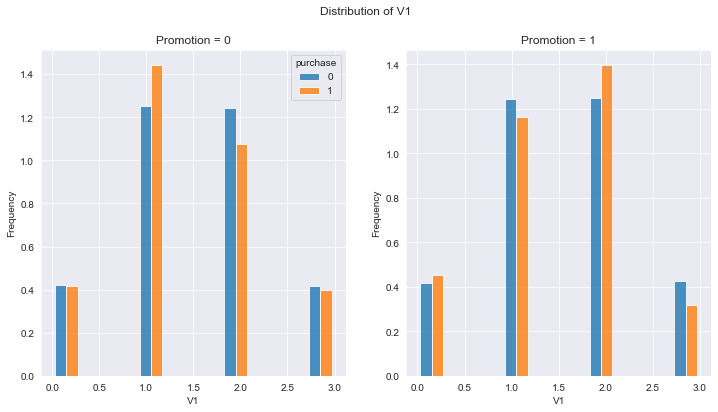

In [5]:
fig, _ = plot_disc_var(train_data, 'V1', figsize=(12, 6), density=True, alpha=0.8)
fig.suptitle("Distribution of V1");

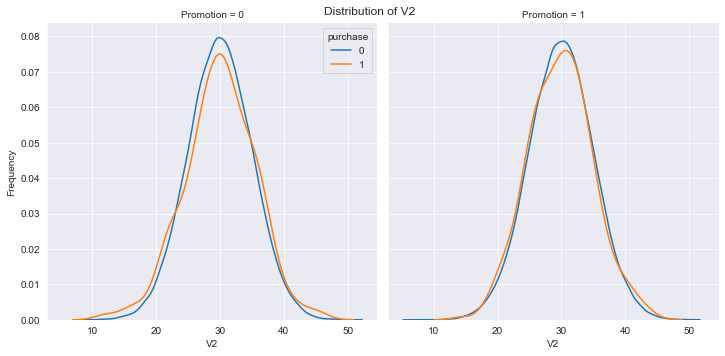

In [6]:
g = sns.FacetGrid(train_data, hue='purchase', col='Promotion', height=5,
                 legend_out=False)
g.map(sns.distplot, 'V2', hist=False)
g.set_ylabels("Frequency")
g.add_legend()
g.fig.suptitle("Distribution of V2");

Note there is very little difference in distribution between `purchase` classes so the variable `V2` is unlikely to be useful for prediction.

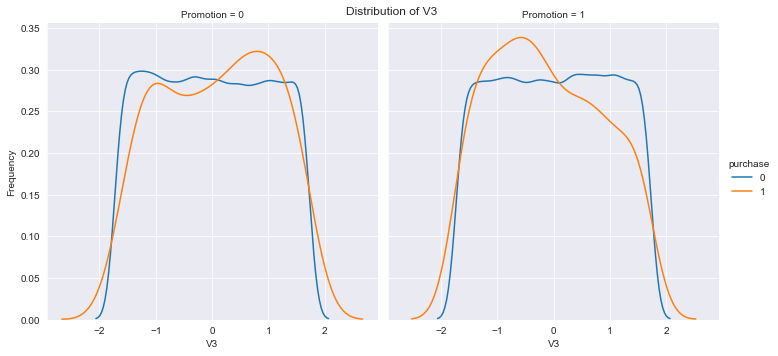

In [7]:
g = sns.FacetGrid(train_data, hue='purchase', col='Promotion', height=5)
g.map(sns.distplot, 'V3', hist=False)
g.set_ylabels("Frequency")
g.add_legend()
g.fig.suptitle("Distribution of V3");

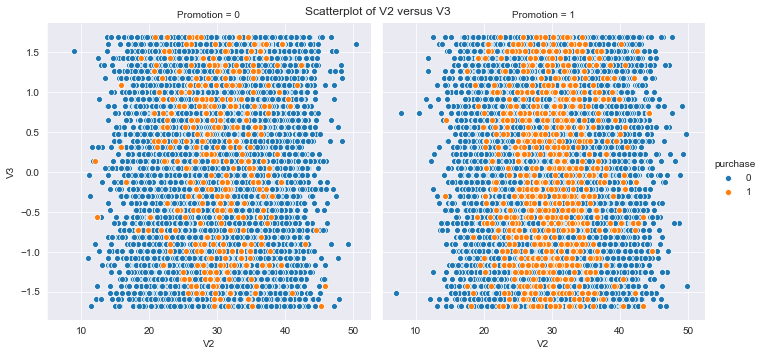

In [8]:
g = sns.FacetGrid(train_data, hue='purchase', col='Promotion', height=5)
g.map(sns.scatterplot, 'V2', 'V3');
g.add_legend()
g.fig.suptitle("Scatterplot of V2 versus V3");

This scatterplot suggests the classes will be difficult to separate, adding further incentive to drop `V2`.

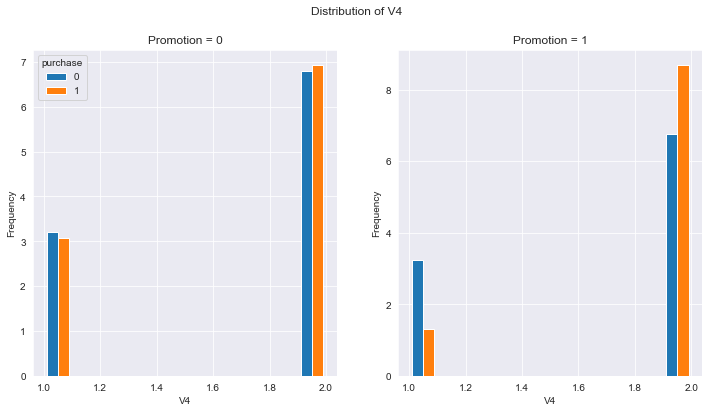

In [9]:
fig, _ = plot_disc_var(train_data, 'V4', figsize=(12, 6), density=True)
fig.suptitle("Distribution of V4");

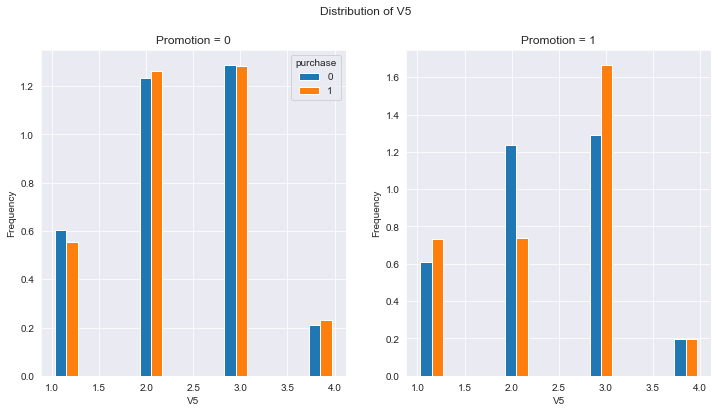

In [10]:
fig, _ = plot_disc_var(train_data, 'V5', figsize=(12, 6), density=True)
fig.suptitle("Distribution of V5");

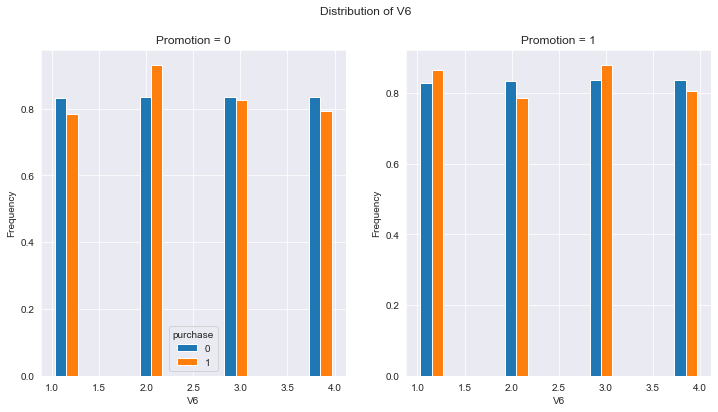

In [11]:
fig, _ = plot_disc_var(train_data, 'V6', figsize=(12, 6), density=True)
fig.suptitle("Distribution of V6");

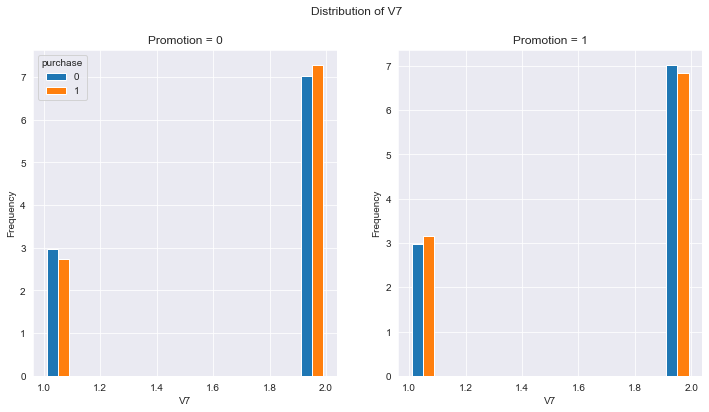

In [12]:
fig, _ = plot_disc_var(train_data, 'V7', figsize=(12, 6), density=True)
fig.suptitle("Distribution of V7");

Notice the target class distributions for `V4-V7` are fairly balanced for the control group and less balanced for the treatment group, suggesting this are more useful features for classification for the treatment group model. 

Moreover, differences between distributions for control and treament groups suggest that it might be better to train a single classifer for both treatment and control groups, rather than separate classifiers. We'll compare both strategies.

## Modeling

Now we'll try to predict whether customers should recieve a promotion in order to maximize IRR and NIT. 

Our overall idea is to focus on those customers for whom the promotion has the greatest effect. To do this we'd like to send the promotion to a customer if they're more likely to purchase than not if they're given the promotion, and less likely to purchase than not if they're not given the promotion. 

More formally, let $V = (V_1, \dots, V_7)$, `Promotion` = $X$, `Purchase` = $Y$. Then if a customer has values $V = v$, then we want to predict $\hat{y} = 1$ if

$$
\begin{align}
\hat{P}(Y = 1| X = 1, V = v) > \alpha \hat{P}(Y = 1| X = 0, V = v)\\
\hat{P}(Y = 0| X = 0, V = v) > \beta \hat{P}(Y = 1| X = 0, V = v)
\end{align}
$$

Here $\alpha, \beta$ are probability thresholds that can be tuned. This suggests a couple strategies

Strategy 1: Train two classifiers $C_a, C_b$, one for the control group and one for the treatment group. Then combine their respective predictions $\hat{y}_a, \hat{y}_b$ to predict

$$\hat{y} = \begin{cases} 1 &\hat{y}_a = 0\,\text{and}\,\hat{y}_b = 1\\
0 & \text{otherwise}
\end{cases}
$$

Strategy 2: Create new indicator features for $(X, Y) = (1, 1)$ (recieved the promotion and purchased) and $(X, Y) = (1, 0)$ (recieved the promotion and didn't purchase) and train two classifiers $C_a, C_b$ with these features as response. Then combine their respective predictions as in strategy 1.

We'll compare both strategies.

For classification, we'll use `xgboost`'s gradient boosted classifier, which allows us to optimize ROC-AUC.

### Strategy 1: Separate Classifiers.

First we'll train separate classifiers on the treatment and control data. Since our classes are highly imbalanced (for both groups), we'll upsample the minority class with [SMOTE](https://arxiv.org/pdf/1106.1813.pdf). 

Note scaling the training data isn't necessary since our classifiers are decision-tree based.

In [2]:
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

def strategy1_clf(train_data, features, random_state=33, cont_params={}, 
                  treat_params={}, rounds=10):
    """Train classifers for treatment and control groups."""
    # split data into treatment and control groups
    cont, treat = train_data.query('Promotion == 0'), train_data.query('Promotion == 1')

    # train and test split
    X_cont, y_cont = cont[features], cont['purchase']
    X_treat, y_treat = treat[features], treat['purchase']
    X_cont_train, X_cont_val, y_cont_train, y_cont_val = train_test_split(X_cont, y_cont, 
                                                                          test_size=0.2,
                                                                          random_state=random_state)
    X_treat_train, X_treat_val, y_treat_train, y_treat_val = train_test_split(X_treat, y_treat, 
                                                                      test_size=0.2,
                                                                      random_state=random_state)

    # oversample minority with SMOTE
    over = SMOTE(random_state=random_state, n_jobs=-1)

    # resample
    X_cont_train_up, y_cont_train_up = over.fit_resample(X_cont_train, y_cont_train)
    X_treat_train_up, y_treat_train_up = over.fit_resample(X_treat_train, y_treat_train)

    # create classifiers
    clf_cont = XGBClassifier(**cont_params)
    clf_treat = XGBClassifier(**treat_params)
    
    # fit models for control and experimental with 
    cont_eval_set = [(X_cont_train_up.values, y_cont_train_up), (X_cont_val.values, y_cont_val)]
    treat_eval_set = [(X_treat_train_up.values, y_treat_train_up), (X_treat_val.values, y_treat_val)]
    clf_cont.fit(X_cont_train_up.values, y_cont_train_up, 
                 eval_metric="auc", verbose=True, 
                 eval_set=cont_eval_set,
                 early_stopping_rounds=rounds)
    clf_treat.fit(X_treat_train_up.values, y_treat_train_up,
                eval_metric="auc", verbose=True, 
                eval_set=treat_eval_set,
                early_stopping_rounds=rounds)
    
    return clf_cont, clf_treat, cont_eval_set, treat_eval_set 

In [14]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
cont_params=treat_params={'random_state': 33, 'n_jobs': -1}
clf_cont, clf_treat, cont_eval_set, treat_eval_set  = strategy1_clf(train_data, features,
                                                                    cont_params=cont_params,
                                                                    treat_params=treat_params)

[0]	validation_0-auc:0.70366	validation_1-auc:0.52978
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.74504	validation_1-auc:0.54494
[2]	validation_0-auc:0.78627	validation_1-auc:0.52083
[3]	validation_0-auc:0.82141	validation_1-auc:0.51219
[4]	validation_0-auc:0.83782	validation_1-auc:0.52647
[5]	validation_0-auc:0.84418	validation_1-auc:0.52245
[6]	validation_0-auc:0.86241	validation_1-auc:0.53184
[7]	validation_0-auc:0.87313	validation_1-auc:0.52156
[8]	validation_0-auc:0.87855	validation_1-auc:0.52468
[9]	validation_0-auc:0.89512	validation_1-auc:0.52008
[10]	validation_0-auc:0.89771	validation_1-auc:0.52018
[11]	validation_0-auc:0.90691	validation_1-auc:0.52824
Stopping. Best iteration:
[1]	validation_0-auc:0.74504	validation_1-auc:0.54494

[0]	validation_0-auc:0.70933	validation_1-auc:0.61317
Multiple eval metrics have been passed: 'validation_1-auc'

Let's look at AUC curves for these models during training.

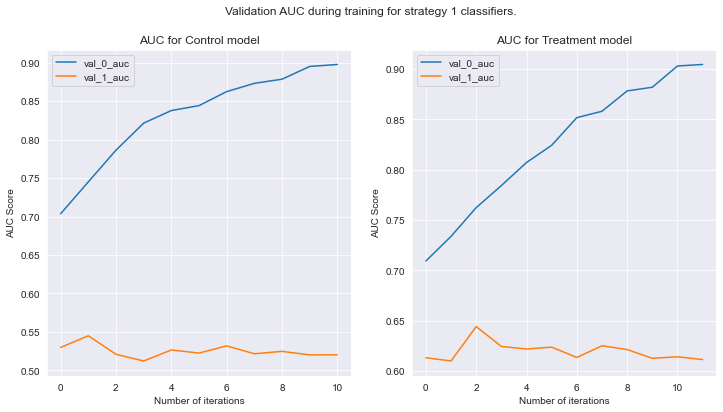

In [15]:
def plot_evals_results(clf_0, clf_1, clf_0_name, clf_1_name,):
    """Plot AUC curves for strategy 1 classifiers"""
    res_0 = clf_0.evals_result()
    res_1 = clf_1.evals_result()
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    x_0 = np.arange(len(res_0['validation_0']['auc']))
    axs[0].plot(x_0, res_0['validation_0']['auc'], label='val_0_auc')
    axs[0].plot(x_0, res_0['validation_1']['auc'], label='val_1_auc')
    axs[0].legend()
    axs[0].set_xlabel('Number of iterations')
    axs[0].set_ylabel('AUC Score')
    axs[0].set_title(f'AUC for {clf_0_name}')
    x_1 = np.arange(len(res_1['validation_0']['auc']))
    axs[1].plot(x_1, res_1['validation_0']['auc'], label='val_0_auc')
    axs[1].plot(x_1, res_1['validation_1']['auc'], label='val_1_auc')
    axs[1].legend()
    axs[1].set_xlabel('Number of iterations')
    axs[1].set_ylabel('AUC Score')
    axs[1].set_title(f'AUC for {clf_1_name}')
    fig.suptitle("Validation AUC during training for strategy 1 classifiers.");
    
plot_evals_results(clf_cont, clf_treat, "Control model", "Treatment model")

AUC isn't really improving on the positive class, which is a good sign we're not overfitting.

#### Tuning probability thresholds

In [3]:
# predict probabilities
from sklearn.metrics import roc_auc_score, f1_score

def to_labels(y_prob, threshold):
    """Classify as positive all instances greater than probability threshold."""
    return (y_prob >= threshold).astype('int')

def plot_prob_thresh(clf, eval_set, title=''):
    """Plot ROC-AUC and F1 scores for different probability thresholds."""
    (X_val, y_val) = eval_set[1]
    y_prob = clf.predict_proba(X_val)
    # get probabilities for specified class
    y_prob = y_prob[:,1]
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # if negative class, change lables for 
    roc_auc_scores = [roc_auc_score(y_val, to_labels(y_prob, t)) for t in thresholds]
    # evaluate each threshold
    f1_scores = [f1_score(y_val, to_labels(y_prob, t)) for t in thresholds]
    # plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(thresholds, roc_auc_scores)
    axs[0].set_xlabel('Threshold')
    axs[0].set_ylabel('ROC-AUC')
    axs[0].set_title('ROC-AUC scores by probability threshold')
    axs[1].plot(thresholds, f1_scores)
    axs[1].set_xlabel('Threshold')
    axs[1].set_ylabel('F1')
    axs[1].set_title('F1 scores by probability threshold')
    fig.suptitle(title)
    # get best thresholds
    roc_auc_thresh = thresholds[np.argmax(roc_auc_scores)]
    f1_thresh= thresholds[np.argmax(roc_auc_scores)]
    
    return roc_auc_thresh, f1_thresh 

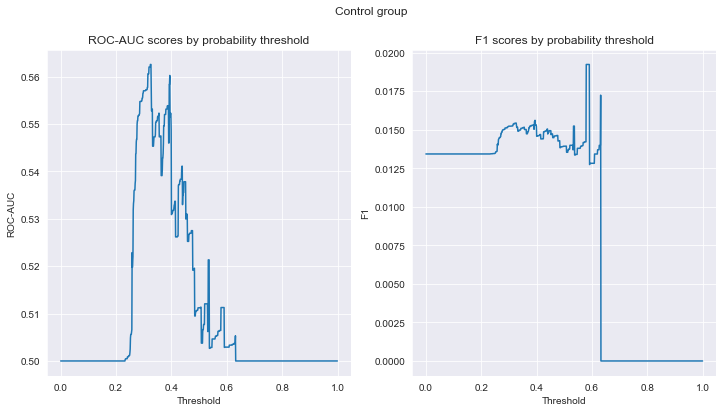

In [17]:
cont_thresh, _ = plot_prob_thresh(clf_cont, cont_eval_set, 'Control group')

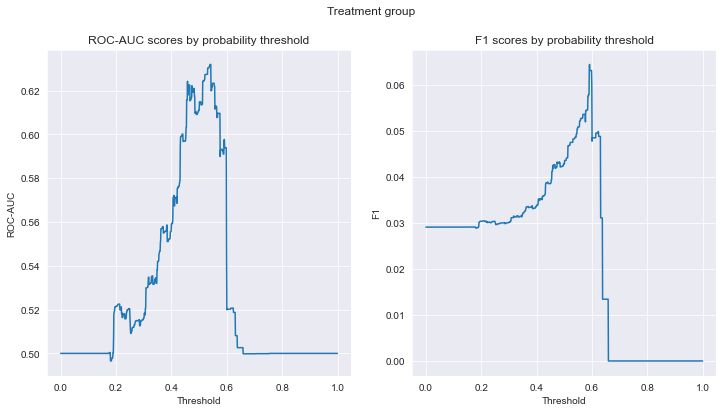

In [18]:
treat_thresh, _ = plot_prob_thresh(clf_treat, treat_eval_set, 'Treatment group')

In [19]:
print(f'Control best threshold= {cont_thresh}')
print(f'Treatment best threshold= {treat_thresh}')

Control best threshold= 0.324
Treatment best threshold= 0.539


### Strategy 2: New Responses

Next, we'll train classifiers on the same data, but for different responses. The first 

In [4]:
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split

def strategy2_clf(train_data, features, random_state=33, clf_11_params={}, 
                  clf_00_params={}, rounds=10):
    """Train classifiers for new responses."""
    # new responses
    train_data['(1,1)'] = ((train_data['Promotion'] == 1) & 
                           (train_data['purchase'] == 1)).astype('int')
    train_data['(0,0)'] = ((train_data['Promotion'] == 0) & 
                           (train_data['purchase'] == 0)).astype('int')
    # (1, 1) data
    response = '(1,1)'
    X, y_11 = train_data[features], train_data[response]
    response = '(0,0)'
    _, y_00 = train_data[features], train_data[response]
        
    X_train, X_val, y_11_train, y_11_val = train_test_split(X, y_11, test_size=0.2,
                                                            random_state=random_state)
    _, _, y_00_train, y_00_val = train_test_split(X, y_00, test_size=0.2,
                                                  random_state=random_state)

    # oversample minority with SMOTE
    over = SMOTE(random_state=random_state, n_jobs=-1)

    # resample
    X_11_train_up, y_11_train_up = over.fit_resample(X_train, y_11_train)
    X_00_train_up, y_00_train_up = over.fit_resample(X_train, y_00_train)

    # create classifiers
    clf_11 = XGBClassifier(**clf_11_params)
    clf_00 = XGBClassifier(**clf_00_params)
    
    # fit models for 11 and 00 response
    eval_set_11 = [(X_11_train_up.values, y_11_train_up), (X_val.values, y_11_val)]
    eval_set_00 = [(X_00_train_up.values, y_00_train_up), (X_val.values, y_00_val)]
    clf_11.fit(X_11_train_up.values, y_11_train_up, 
                 eval_metric="auc", verbose=True, 
                 eval_set=eval_set_11,
                 early_stopping_rounds=rounds)
    clf_00.fit(X_00_train_up.values, y_00_train_up,
                eval_metric="auc", verbose=True, 
                eval_set=eval_set_00,
                early_stopping_rounds=rounds)
    
    return clf_11, clf_00, eval_set_11, eval_set_00 

In [21]:
clf_11_params = clf_00_params = {'random_state': 33, 'n_jobs': -1}
clf_11, clf_00, eval_set_11, eval_set_00  = strategy2_clf(train_data, features,
                                                          clf_11_params=clf_11_params,
                                                          clf_00_params=clf_00_params)

[0]	validation_0-auc:0.70758	validation_1-auc:0.54947
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.75412	validation_1-auc:0.59386
[2]	validation_0-auc:0.77327	validation_1-auc:0.57462
[3]	validation_0-auc:0.78493	validation_1-auc:0.57905
[4]	validation_0-auc:0.80837	validation_1-auc:0.57269
[5]	validation_0-auc:0.82632	validation_1-auc:0.56790
[6]	validation_0-auc:0.84422	validation_1-auc:0.56954
[7]	validation_0-auc:0.84630	validation_1-auc:0.57145
[8]	validation_0-auc:0.86392	validation_1-auc:0.56576
[9]	validation_0-auc:0.87034	validation_1-auc:0.56812
[10]	validation_0-auc:0.88919	validation_1-auc:0.56920
[11]	validation_0-auc:0.89309	validation_1-auc:0.56170
Stopping. Best iteration:
[1]	validation_0-auc:0.75412	validation_1-auc:0.59386

[0]	validation_0-auc:0.52151	validation_1-auc:0.49273
Multiple eval metrics have been passed: 'validation_1-auc'

Let's look at AUC curves for these models during training.

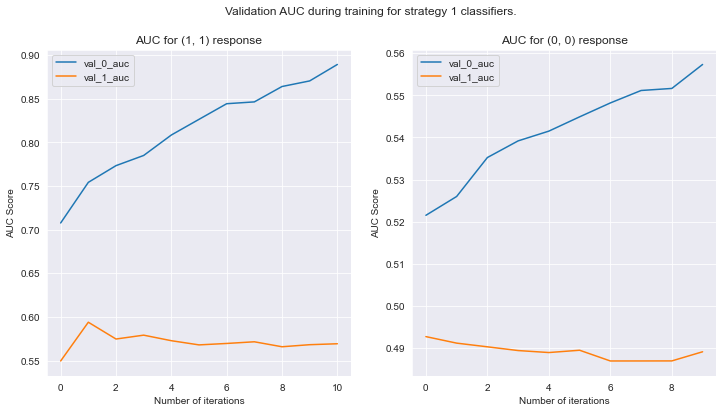

In [22]:
plot_evals_results(clf_11, clf_00, '(1, 1) response', '(0, 0) response')

Again, AUC isn't really improving on the positive class, which is a good sign we're not overfitting.

#### Tuning probability thresholds

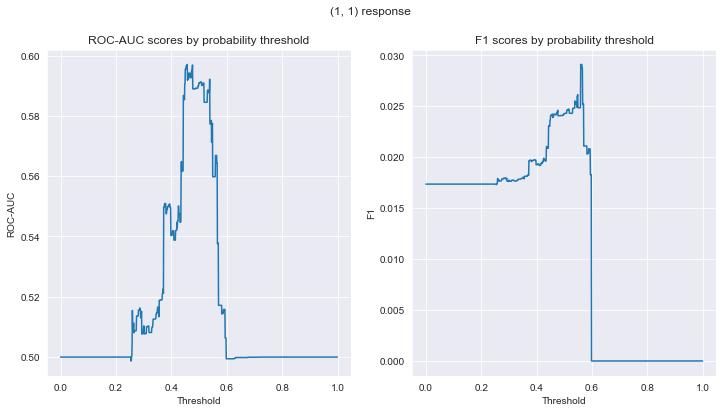

In [23]:
thresh_11, _ = plot_prob_thresh(clf_11, eval_set_11, '(1, 1) response')

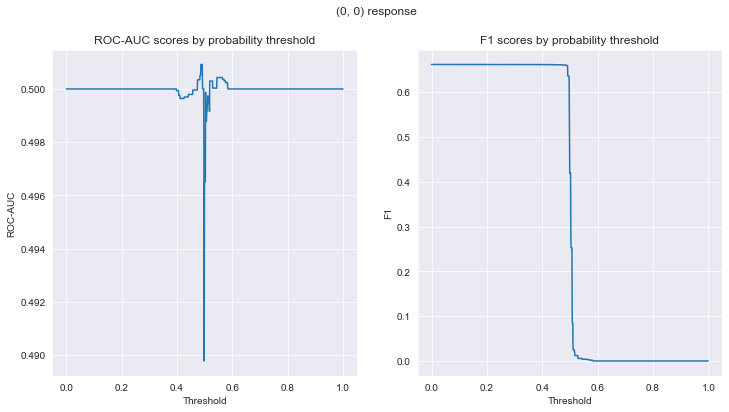

In [24]:
thresh_00, _ = plot_prob_thresh(clf_00, eval_set_00, '(0, 0) response')

In [25]:
print(f'(1, 1) best threshold= {thresh_11}')
print(f'(0, 0) best threshold= {thresh_00}')

(1, 1) best threshold= 0.457
(0, 0) best threshold= 0.486


## Compare strategies

Now we'll compare IRR and NIR metric results for the two strategies.

In [26]:
def promotion_strategy_1(clf_cont, clf_treat, cont_thresh, treat_thresh, features,
                         test_data):
    """Select customers for promotion based on strategy 1."""
    X = test_data[features].values
    
    # get thresholded control and experimental model predictions
    y_cont_pred = to_labels(clf_cont.predict_proba(X), cont_thresh)[:,1]
    y_treat_pred = to_labels(clf_treat.predict_proba(X), treat_thresh)[:,1]
    
    # combine predictions
    y_comb_pred = np.array([])
    for (y_cont, y_treat) in zip(y_cont_pred, y_treat_pred):
        if y_cont == 0 and y_treat == 1:
            y_comb_pred = np.append(y_comb_pred, 1)
        else:
            y_comb_pred = np.append(y_comb_pred, 0)
    
    promotion = np.array(['Yes' if y == 1 else 'No' for y in y_comb_pred])
    
    return promotion

def promotion_strategy_2(clf_11, clf_00, thresh_11, thresh_00, features,
                         test_data):
    """Select customers for promotion based on strategy 2."""
    X = test_data[features].values
    
    # get thresholded control and experimental model predictions
    y_11_pred = to_labels(clf_cont.predict_proba(X), cont_thresh)[:,1]
    y_00_pred = to_labels(clf_treat.predict_proba(X), treat_thresh)[:,1]
    
    # combine predictions
    y_comb_pred = np.array([])
    for (y_11, y_00) in zip(y_11_pred, y_00_pred):
        if y_11 == 1 and y_00 == 1:
            y_comb_pred = np.append(y_comb_pred, 1)
        else:
            y_comb_pred = np.append(y_comb_pred, 0)
    
    promotion = np.array(['Yes' if y == 1 else 'No' for y in y_comb_pred])
    
    return promotion

In [27]:
from functools import partial

print("Strategy 1 results:\n")
f1 = partial(promotion_strategy_1, clf_cont, clf_treat, cont_thresh, treat_thresh,
            features)
test_results(f1);

Strategy 1 results:

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0355.

Your nir with this strategy is 102.45.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


In [28]:
print("Strategy 2 results:\n")
f2 = partial(promotion_strategy_2, clf_11, clf_00, thresh_11, thresh_00, features)
test_results(f2);

Strategy 2 results:

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0190.

Your nir with this strategy is 262.80.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


## Tune final model

Using all features, it looks like strategy 2 is more promising! Lets tune a few parameters of the two classifiers using CV grid search.

In [29]:
random_state = 33

# new responses
train_data['(1,1)'] = ((train_data['Promotion'] == 1) & 
                       (train_data['purchase'] == 1)).astype('int')
train_data['(0,0)'] = ((train_data['Promotion'] == 0) & 
                       (train_data['purchase'] == 0)).astype('int')
# (1, 1) data
response = '(1,1)'
X_train, y_11_train = train_data[features], train_data[response]
response = '(0,0)'
_, y_00_train = train_data[features], train_data[response]

# oversample minority with SMOTE
over = SMOTE(random_state=random_state, n_jobs=-1)

# resample
X_11_train_up, y_11_train_up = over.fit_resample(X_train, y_11_train)
X_00_train_up, y_00_train_up = over.fit_resample(X_train, y_00_train)

In [5]:
from sklearn.model_selection import GridSearchCV
from dask.distributed import Client
import joblib
import time

def grid_search_params(clf_11, clf_00, param_grid):
    # grid search number of estimators for both responses
    grid_search_11 =  GridSearchCV(clf_11, param_grid, scoring="roc_auc", cv=5)
    grid_search_00 = GridSearchCV(clf_00, param_grid, scoring="roc_auc", cv=5)

    # use Dask for easy multiprocessing
    client = Client(processes=False)
    with joblib.parallel_backend('dask'):
        start = time.time()
        grid_search_11.fit(X_11_train_up, y_11_train_up)
        print(f'Grid search for clf_11 finished, total time {time.time() - start}')
        start = time.time()
        grid_search_00.fit(X_00_train_up, y_00_train_up)
        print(f'Grid search for clf_00 finished finished, total time {time.time() - start}')
        
    return grid_search_11, grid_search_00

In [31]:
n_estimators = [100, 300, 500, 700]
param_grid = dict(n_estimators=n_estimators)
grid_search_11, grid_search_00 = grid_search_params(clf_11, clf_00, param_grid)

Grid search for clf_11 finished, total time 696.899453163147
Grid search for clf_00 finished finished, total time 292.51763129234314


In [32]:
# print best cv AUC scores and params and store best params
print(f'Best 5-fold cv AUC score for clf_11={grid_search_11.best_score_}')
print(f'Best number of estimators for clf_11={grid_search_11.best_params_}')
print(f'Best 5-fold cv AUC score for clf_00={grid_search_00.best_score_}')
print(f'Best number of estimators for clf_00={grid_search_11.best_params_}')
clf_11.set_params(**grid_search_11.best_params_)
clf_00.set_params(**grid_search_00.best_params_);

Best 5-fold cv AUC score for clf_11=0.9985236535649872
Best number of estimators for clf_11={'n_estimators': 500}
Best 5-fold cv AUC score for clf_00=0.5556229948719813
Best number of estimators for clf_00={'n_estimators': 500}


In [33]:
# grid search max depth for both responses
max_depth=[9, 10, 11]
param_grid = dict(max_depth=max_depth)
grid_search_11, grid_search_00 = grid_search_params(clf_11, clf_00, param_grid)

/Users/home/opt/anaconda3/envs/dsnd/lib/python3.8/site-packages/distributed/node.py:240: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65175 instead
  warnings.warn(


Grid search for clf_11 finished, total time 1132.650799036026
Grid search for clf_00 finished finished, total time 116.87905478477478


In [34]:
# print best cv AUC scores and params and store best params
print(f'Best 5-fold cv AUC score for clf_11={grid_search_11.best_score_}')
print(f'Best max_depth for clf_11={grid_search_11.best_params_}')
print(f'Best 5-fold cv AUC score for clf_00={grid_search_00.best_score_}')
print(f'Best max_depth for clf_00={grid_search_11.best_params_}')
clf_11.set_params(**grid_search_11.best_params_)
clf_00.set_params(**grid_search_00.best_params_);

Best 5-fold cv AUC score for clf_11=0.9981690673823822
Best max_depth for clf_11={'max_depth': 11}
Best 5-fold cv AUC score for clf_00=0.5011077941650942
Best max_depth for clf_00={'max_depth': 11}


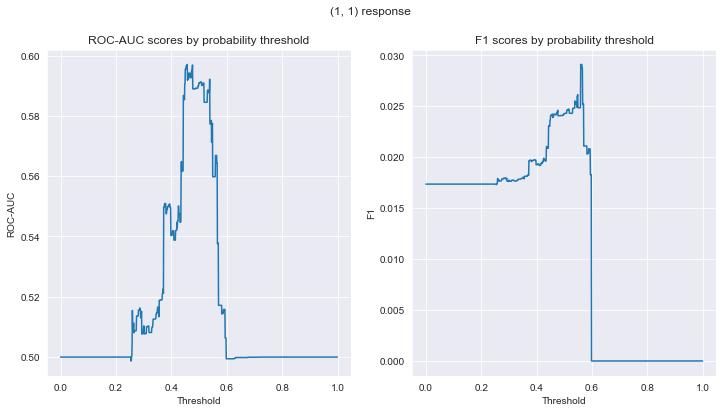

In [35]:
# tune probability threshold for first classifier
thresh_11, _ = plot_prob_thresh(clf_11, eval_set_11, '(1, 1) response')

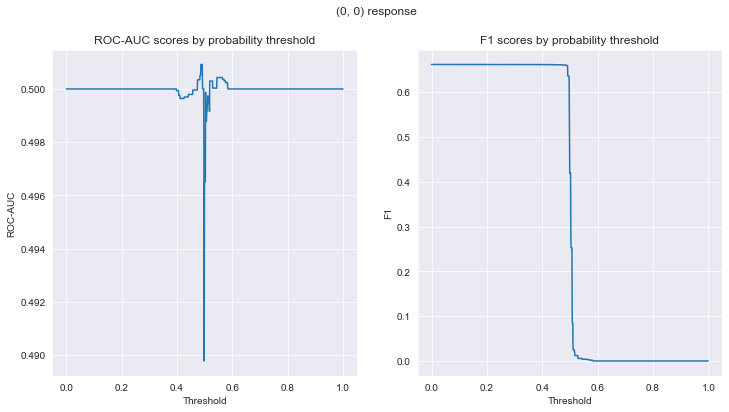

In [36]:
thresh_00, _ = plot_prob_thresh(clf_00, eval_set_00, '(0, 0) response')

In [37]:
print(f'(1, 1) best threshold= {thresh_11}')
print(f'(0, 0) best threshold= {thresh_00}')

(1, 1) best threshold= 0.457
(0, 0) best threshold= 0.486


In [38]:
# retrain classifiers with tuned params
clf_11, clf_00, _, _ = strategy2_clf(train_data, features,
                                     clf_11_params=clf_11.get_params(),
                                     clf_00_params=clf_00.get_params())

[0]	validation_0-auc:0.84205	validation_1-auc:0.54932
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87943	validation_1-auc:0.55004
[2]	validation_0-auc:0.89391	validation_1-auc:0.54276
[3]	validation_0-auc:0.91060	validation_1-auc:0.53569
[4]	validation_0-auc:0.93342	validation_1-auc:0.53604
[5]	validation_0-auc:0.94944	validation_1-auc:0.53828
[6]	validation_0-auc:0.95312	validation_1-auc:0.53581
[7]	validation_0-auc:0.96205	validation_1-auc:0.53166
[8]	validation_0-auc:0.96343	validation_1-auc:0.53521
[9]	validation_0-auc:0.96487	validation_1-auc:0.53212
[10]	validation_0-auc:0.97665	validation_1-auc:0.53409
[11]	validation_0-auc:0.97707	validation_1-auc:0.53425
Stopping. Best iteration:
[1]	validation_0-auc:0.87943	validation_1-auc:0.55004

[0]	validation_0-auc:0.54401	validation_1-auc:0.49024
Multiple eval metrics have been passed: 'validation_1-auc'

In [39]:
print("Strategy 2 tuned results:\n")
f2 = partial(promotion_strategy_2, clf_11, clf_00, thresh_11, thresh_00, features)
test_results(f2);

Strategy 2 tuned results:

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0190.

Your nir with this strategy is 262.80.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


The tuning had no effect on IRR and NIR.